## 1. Loading the data

### 1.1. Loading libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import glob, os, json
from pathlib import Path
import time

In [2]:
start_time = time.time()

places = []

for file in Path("C:\\Users\\Przem\\Code\\Analysis-And-Visualization-For-Bike-Sharing-Systems-In-Warsaw\\data").glob("*.json"):   # ścieżka dostępu do katalogu, gdzie przechowywane są pliki JSON

    with open(file) as json_file:
        data = json.load(json_file)

    for result in data:
        for place in result["places"]:
            place["date"] = file.stem 
            places.append(place)

df = pd.DataFrame(places)

print("--- %s seconds ---" % (time.time() - start_time))

--- 148.11247158050537 seconds ---


In [3]:
print(df.shape)
print(df.columns)

(1478785, 16)
Index(['uid', 'lat', 'lng', 'name', 'spot', 'number', 'bikes', 'bike_racks',
       'free_racks', 'terminal_type', 'bike_numbers', 'bike_types',
       'place_type', 'rack_locks', 'date', 'maintenance'],
      dtype='object')


In [4]:
df_ = df.drop(df.columns[[4, 5, 9, 11, 12, 13, 15]], axis = 1)

In [5]:
def data_preprocessing_1(df): # wstępne przetworzenie danych
    
# rozbicie nazw JSONów na rok, miesiąc, dzień, godzinę i minuty
    df_ = pd.DataFrame({'year': df['date'].str[0:4],
                     'month': df['date'].str[4:6],
                     'day': df['date'].str[6:8],
                     'hour': df['date'].str[9:11],
                     'minutes': df['date'].str[11:13]})
    df['date'] = pd.to_datetime(df_)  # stworzenie z powyższych "części" nazwy JSONów kolumny z datą
    df['day_of_week'] = df['date'].dt.day_name() # stworzenie nowej kolumny z dniem tygodnia
    df['city_code'] = '352200375' # kod stacji - w tym przypadku dla Warszawy
    df['date_normalize'] = df['date'] 
    # stworzenie kolumny z datą w postaci Y-M-D
    df['date_normalize'] = pd.to_datetime(df['date_normalize']).dt.strftime('%Y-%m-%d') 
    
    return df

In [6]:
def data_preprocessing_2(df):
    df = df[df.date_normalize != '2018-04-02'] # wyrzucenie danych z 2018-04-02 (ponieważ w tym dniu dostępne są dane tylko do godziny 3:00)
    df['bikes'] = df['bikes'].replace('?', np.nan).astype(float)  # wyrzucenie '?' z kolumny 'bikes'
    df['bike_racks'] = pd.to_numeric(df['bike_racks'])  # przekonwertowanie kolumny z ilością stanowisk na stacji na wartości numeryczne
    return df
    

In [7]:
data = data_preprocessing_1(df_)
df = data_preprocessing_2(data)

C:\Users\Przem\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Przem\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [8]:
df_temp_march = pd.read_csv('B00300S_2018_03.csv') # wartości temperatur odnotowane dla marca 2018
df_temp_april = pd.read_csv('B00300S_2018_04.csv') # wartości temperatur odnotowane dla kwietnia 2018

In [9]:
df_temp_march.head(3)

,249190890;B00300S;2018-03-01 00:00;-19,10;
0,249190890;B00300S;2018-03-01 00:10;-19,40;
1,249190890;B00300S;2018-03-01 00:20;-19,20;
2,249190890;B00300S;2018-03-01 00:30;-19,20;


In [10]:
df_temp_march = df_temp_march.fillna(0) 
df_temp_april = df_temp_april.fillna(0)

temperature_march = df_temp_march.rename(columns={"249190890;B00300S;2018-03-01 00:00;-19": "temp1", "10;": "temp2"})
temperature_april = df_temp_april.rename(columns={"249190890;B00300S;2018-04-01 00:00;7": "temp1", "20;": "temp2"})

# rozdzielenie pierwszej kolumny na kod stacji i datę odczytu temperatury
temperature_df = pd.DataFrame(columns = ['city_code', 'date'])
temperature_df['date'] = temperature_march['temp1'].str[18:34]
temperature_df['city_code'] = temperature_march['temp1'].str[0:9]

In [11]:
total_temp = pd.DataFrame(columns = ['city_code', 'date', 'temperature']) 
total_temp['date'] = temperature_df['date'].append(temperature_april['temp1'].str[18:34], ignore_index = True)
total_temp['city_code'] = temperature_df['city_code'].append(temperature_april['temp1'].str[0:9], ignore_index = True)

In [12]:
# "ekstrakcja" z ramki danych roku, miesiaca, dnia, godziny i minuty
cops = pd.DataFrame({'year': total_temp['date'].str[0:4],
                 'month': total_temp['date'].str[5:7],
                 'day': total_temp['date'].str[8:11],
                 'hour': total_temp['date'].str[11:13],
                 'minutes': total_temp['date'].str[14:17]})

In [13]:
total_temp['date'] = pd.to_datetime(cops) # stworzenie kolummy z datą odczytu wartości temperatury

In [14]:
# przekonwertowanie drugiej kolumny na str i "wydobycie" z niej części dziesiętnej
temperature_march['temp2'] = temperature_march['temp2'].astype(str).str[0]  
temperature_april['temp2'] = temperature_april['temp2'].astype(str).str[0]

# "wydobycie" z pierwszej kolumny wartości jedności, bądź dziesiątek temperatur
temperature_march['temp1'] = temperature_march['temp1'].str[35:]
temperature_march['temp1'] = temperature_march['temp1'].replace(';','', regex=True)

temperature_april['temp1'] = temperature_april['temp1'].str[35:]
temperature_april['temp1'] = temperature_april['temp1'].replace(';','', regex=True)

In [15]:
# połączenie częsci dziesiątek/jedności z pierwszej kolumny z częścią dziesiętną z drugiej kolumny
new_temp1 = temperature_march['temp2'].copy()
temperature_march['temp1'] = temperature_march['temp1'].str.cat(new_temp1, sep='.')
temperature_march= temperature_march.drop(temperature_march.columns[[1]], axis=1)

new_temp2 = temperature_april['temp2'].copy()
temperature_april['temp1'] = temperature_april['temp1'].str.cat(new_temp2, sep='.')
temperature_april= temperature_april.drop(temperature_april.columns[[1]], axis=1)

In [16]:
temp_all = pd.concat([temperature_march, temperature_april])
temp_all = temp_all.reset_index(drop=True) 


In [17]:
total_temp['temperature'] = temp_all

In [18]:
df_ = pd.merge(df, total_temp, how='left', on=['date', 'city_code']) # dołączanie do głównej ramki danych informacji o temperaturze

In [19]:
df_['temperature'] = pd.to_numeric(df_['temperature']) # zmiana typu danych kolumny z wartościami temp. z str na int

In [21]:
rainfall_all = pd.read_excel('dane_opadowe_03_04.xlsx')

In [22]:
rainfall_all = rainfall_all.drop(columns = [352200375, 'B00606S' ])
rainfall_all = rainfall_all.rename(columns={"godz": "date", "suma": "rainfall"})
rainfall_all['date'] = pd.to_datetime(rainfall_all['date'])

In [23]:
rainfall_all.tail()

,date,rainfall
691,2018-04-01 19:00:00,0.0
692,2018-04-01 20:00:00,0.0
693,2018-04-01 21:00:00,0.0
694,2018-04-01 22:00:00,0.1
695,2018-04-01 23:00:00,0.0


In [24]:
df = pd.merge(df_, rainfall_all, how='left', on=['date', 'date']) # dołączanie do głównej ramki danych informacji o opadach deszczu

In [25]:
df = df.fillna(0) # NaNy z 00:10, 00:20, 00:30 itd. zastąpiono zerami

In [26]:
main_df = df.copy()
main_df.set_index(['date', 'temperature', 'rainfall', 'name'], inplace=True)
main_df.sort_index(inplace=True)

## Preparing data for analysis

In [27]:
warsaw_bikes_df_ = df.pivot_table(index=['date', 'temperature', 'rainfall'],
                     columns='name',
                     values='bikes')

In [28]:
warsaw_bikes_df_.isnull().sum().sort_values(ascending = False).head(30) # wyświetlenie stacji, które zawierają brakujące wartości

name
Klarysew_test                                          4156
al. Jana Pawła II - ul. Anielewicza                    4150
aps szczęśliwicka                                      4065
  Marszałkowska - Złota                                4062
Teststation IT - Adrian | FVT-4 Przed budynkiem        4042
PKN Orlen - Bielańska                                  4035
PKN Orlen - Chodakowska                                4035
PKN Orlen - E-bike Bielańska                           4035
PKN Orlen - Filomatów                                  4035
PKN Orlen - Migdałowa                                  4035
PKN Orlen - Obozowa                                    4035
PKN Orlen - Powsińska                                  4035
PKN Orlen - Wersalska                                  4035
PKN Orlen - Wydawnicza                                 4035
PKN Orlen - Śródziemnomorska                           4035
PKN Orlen - Al. Solidarności                           4035
ul. Waryńskiego-ul. Nowowiejska-Met

In [29]:
warsaw_bikes_df_.iloc[:, warsaw_bikes_df_.columns == 'al. Jana Pawła II - Grzybowska'] = warsaw_bikes_df_.iloc[:, warsaw_bikes_df_.columns == 'al. Jana Pawła II - Grzybowska'].fillna(method = 'ffill')
warsaw_bikes_df_.iloc[:, warsaw_bikes_df_.columns == 'Wołoska - Odyńca'] = warsaw_bikes_df_.iloc[:, warsaw_bikes_df_.columns == 'Wołoska - Odyńca'].fillna(method = 'ffill')
warsaw_bikes_df_.iloc[:, warsaw_bikes_df_.columns == 'Marszałkowska - al. Solidarności'] = warsaw_bikes_df_.iloc[:, warsaw_bikes_df_.columns == 'Marszałkowska - al. Solidarności'].fillna(method = 'ffill')
warsaw_bikes_df_.iloc[:, warsaw_bikes_df_.columns == 'Czerniakowska - Gagarina'] = warsaw_bikes_df_.iloc[:, warsaw_bikes_df_.columns == 'Czerniakowska - Gagarina'].fillna(method = 'ffill')

In [30]:
warsaw_bikes_df_ = warsaw_bikes_df_.transpose()
warsaw_bikes_df_ = warsaw_bikes_df_.dropna() # usunięcie stacji, dla których jest niewystarczająco informacji
warsaw_bikes_df_ = warsaw_bikes_df_.transpose()

In [31]:
warsaw_bikes_df_.isnull().sum().sort_values(ascending = False).head(5)

name
Żwirki i Wigury - Racławicka         0
Marymoncka - Dewajtis                0
Mariensztat                          0
Marszałkowska - Al. Jerozolimskie    0
Marszałkowska - Hoża                 0
dtype: int64

In [32]:
warsaw_bikes_df_

,,name,1 Sierpnia - DK Włochy,11 Listopada - Ratuszowa,11 listopada - Środkowa,Abrahama - Kapelanów AK,Afrykańska - Egipska,Al. Jerozolimskie - Emilii Plater,Aluzyjna - Trąby,Andersa - Długa,Andersa - Muranowska,Anielewicza - Andersa,...,al. Stanów Zjednoczonych - Międzynarodowa,al. Stanów Zjednoczonych - Ostrobramska,al. Wilanowska - Przyczółkowa,al. Zieleniecka - Teatr Powszechny,Światowida - Mehoffera,Żelazna - Chłodna,Żelazna - Grzybowska,Żelazna - Sienna,Żwirki i Wigury - Księcia Trojdena,Żwirki i Wigury - Racławicka
date,temperature,rainfall,,,,,,,,,,,,,,,,,,,,,
2018-03-04 00:00:00,-11.8,0.0,11.0,20.0,15.0,9.0,13.0,11.0,12.0,20.0,20.0,11.0,...,19.0,14.0,12.0,10.0,12.0,10.0,16.0,20.0,8.0,12.0
2018-03-04 00:10:00,-11.9,0.0,11.0,20.0,15.0,9.0,13.0,11.0,12.0,20.0,20.0,11.0,...,19.0,14.0,12.0,10.0,12.0,10.0,16.0,20.0,8.0,12.0
2018-03-04 00:20:00,-11.8,0.0,11.0,20.0,15.0,9.0,13.0,11.0,12.0,20.0,20.0,11.0,...,19.0,14.0,12.0,10.0,12.0,10.0,16.0,20.0,8.0,12.0
2018-03-04 00:40:00,-11.9,0.0,11.0,20.0,15.0,9.0,13.0,11.0,12.0,20.0,20.0,11.0,...,19.0,14.0,12.0,10.0,12.0,10.0,16.0,19.0,8.0,12.0
2018-03-04 00:50:00,-11.8,0.0,11.0,20.0,15.0,9.0,13.0,11.0,12.0,20.0,20.0,11.0,...,19.0,14.0,12.0,10.0,12.0,10.0,16.0,19.0,8.0,12.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-04-01 23:10:00,1.3,0.0,12.0,15.0,12.0,11.0,10.0,23.0,13.0,19.0,17.0,19.0,...,21.0,19.0,12.0,6.0,11.0,12.0,16.0,16.0,12.0,14.0
2018-04-01 23:20:00,1.2,0.0,12.0,15.0,12.0,11.0,10.0,23.0,13.0,19.0,17.0,19.0,...,21.0,19.0,12.0,6.0,11.0,12.0,17.0,16.0,12.0,14.0
2018-04-01 23:30:00,1.1,0.0,12.0,15.0,12.0,11.0,10.0,23.0,13.0,19.0,17.0,19.0,...,21.0,19.0,12.0,6.0,11.0,12.0,17.0,16.0,12.0,14.0


In [33]:
warsaw_bikes_data = warsaw_bikes_df_.diff()
warsaw_bikes_data = warsaw_bikes_data.iloc[1:, :]

In [34]:
# ilość wypożyczonych rowerów to wartość bezwzgledna z różnicy w ilości rowerów na stacji pomiedzy kolejnymi wierszami (przedziałami czasu)
warsaw_bikes_rent = warsaw_bikes_data.copy()
warsaw_bikes_rent[warsaw_bikes_rent > 0] = 0 # przyjazd roweru na stacje - nie uwzględniamy
warsaw_bikes_rent[warsaw_bikes_rent < 0] = abs(warsaw_bikes_rent) 
warsaw_bikes_rent = warsaw_bikes_rent.transpose()


In [35]:
warsaw_bikes_rent = warsaw_bikes_rent.unstack().rename('bikes_rental').reset_index()

In [36]:
warsaw_bikes_rent['weekday'] = warsaw_bikes_rent.date.dt.day_name() # stworzenie kolumny z dniem tygodnia
warsaw_bikes_rent['date_'] = warsaw_bikes_rent.date.dt.date # stworzenie kolumny z datą w formie Y-M-D
warsaw_bikes_rent['hour_'] = warsaw_bikes_rent.date.dt.hour # stworzenie kolumny z godziną

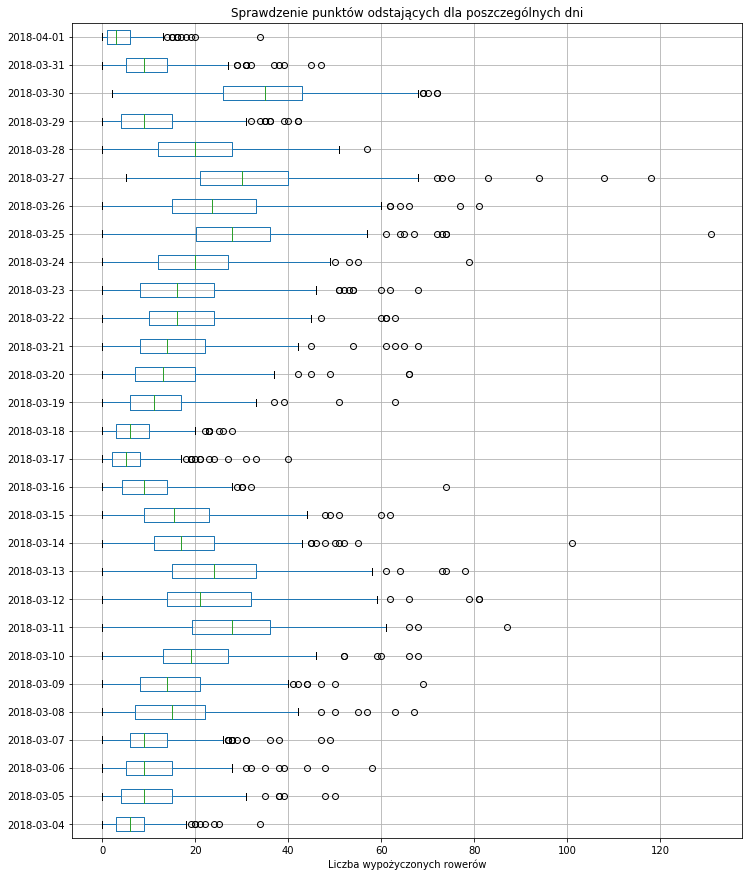

In [37]:
# korzystając z wykresu pudełkowego sprawdzamy występowanie punktów odstających
outpoints_day = warsaw_bikes_rent.pivot_table(index='name', columns=['date_'], values='bikes_rental', aggfunc='sum')
outpoints_day.boxplot(vert=False, figsize=(12,15)).set(title = "Sprawdzenie punktów odstających dla poszczególnych dni", xlabel = "Liczba wypożyczonych rowerów")
plt.show()